In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time
import re
import matplotlib.pyplot as plt



In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException


In the code below, we webscrape the EPU for the newspapers specified.

In [9]:
# Newspapers: user-friendly name -> URL-encoded title
NEWSPAPERS = {
    "Neues Wiener Journal": "Neues%20Wiener%20Journal",
    "Wiener Zeitung": "Wiener%20Zeitung",
    "Neue Freie Presse": "Neue%20Freie%20Presse",
    "Neues Wiener Tagblatt (Tages-Ausgabe)": "Neues%20Wiener%20Tagblatt%20%28Tages-Ausgabe%29",
    "Arbeiter Zeitung": "Arbeiter%20Zeitung",
    "Kärntner Zeitung": "Kärntner%20Zeitung",
    "Allgemeiner Tiroler Anzeiger": "Allgemeiner%20Tiroler%20Anzeiger",
    "Vorarlberger Volksblatt": "Vorarlberger%20Volksblatt",
    "Grazer Volksblatt": "Grazer%20Volksblatt",
    "Linzer Volksblatt": "Linzer%20Volksblatt",
    "Salzburger Chronik": "Salzburger%20Chronik%20für%20Stadt%20und%20Land"
}

# Keywords in one big semicolon-separated string (URL-encoded)
KEYWORDS = (
    "Unsicher%20AND%20Wirtschaft%20OR%20wirtschaftlich%20OR%20Industrie%20OR%20Zentralbank%20OR%20Geldpolitik%20OR%20Kronen%20OR%20Schilling%20OR%20Banksatz%20OR%20Inflation%20OR%20Budget%20OR%20Defizit%20OR%20Haushaltsdefizit%20OR%20Politik%20OR%20Regulierung%20OR%20Krieg%20OR%20Gesetz%20OR%20Steuer%20OR%20Reparationen%20OR%20Reparationszahlungen%20OR%20Krise"
)

# --------------------------------------------------------------------------
# 1. Generate monthly date ranges
# --------------------------------------------------------------------------
def generate_monthly_ranges(start_year=1913, end_year=1937):
    date_ranges = []
    current_date = datetime(start_year, 1, 1)
    last_date = datetime(end_year, 12, 31)

    while current_date <= last_date:
        start_str = current_date.strftime("%Y-%m-%d")
        # End of the current month
        month_end = (current_date.replace(day=28) + timedelta(days=4))
        month_end = month_end.replace(day=1) - timedelta(days=1)
        end_str = month_end.strftime("%Y-%m-%d")
        date_ranges.append((start_str, end_str))
        current_date = month_end + timedelta(days=1)

    return date_ranges

# --------------------------------------------------------------------------
# 2. Build the Selenium driver
# --------------------------------------------------------------------------
def build_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # run headless so no browser opens
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# --------------------------------------------------------------------------
# 3. Scrape function
# --------------------------------------------------------------------------
def scrape_articles_by_newspaper(start_year=1913, end_year=1937):
    """
    For each month from start_year to end_year,
    for each newspaper in NEWSPAPERS,
    fetch number of articles with the given KEYWORDS.
    Returns a list of dicts, each representing one row (month) with columns for each newspaper.
    """
    driver = build_driver()
    wait = WebDriverWait(driver, 20)  # wait up to 20s for page to load
    
    # Prepare all monthly ranges
    monthly_ranges = generate_monthly_ranges(start_year, end_year)

    results = [] 

    for (start_date, end_date) in monthly_ranges:
        # We'll build one row for this month, plus the columns for each newspaper
        row_data = {
            "Start Date": start_date,
            "End Date": end_date
        }

        for newspaper_name, newspaper_url_title in NEWSPAPERS.items():
            # Construct the search URL
            
            url = (
                "https://anno.onb.ac.at/anno-suche/complex?"
                f"text={KEYWORDS}"
                f"&title={newspaper_url_title}"
                f"&language=ger&dateMode=date"
                f"&dateFrom={start_date}&dateTo={end_date}&from=1"
            )

            driver.get(url)

            # Initialise article_count to 0 in case of error
            article_count = 0
            try:
                h3_element = wait.until(
                    EC.visibility_of_element_located((By.CSS_SELECTOR, "h3.flex-grow-1"))
                )
                raw_text = h3_element.text.strip() 

                # Extract digits ignoring punctuation like '.' or ','
                
                match = re.findall(r"\d+", raw_text)
                if match: 
                    joined = "".join(match)
                    article_count = int(joined)
                else:
                    article_count = 0
            except TimeoutException: # Probably no coverage for that date range/newspaper
                article_count = 0
                print(f"No coverage or no results for {newspaper_name}, {start_date}-{end_date}")

            # Store the result in the row
            row_data[newspaper_name] = article_count

        # Done with all newspapers for this month -> add to results
        results.append(row_data)
        print(f"Row for {start_date} - {end_date}: {row_data}")

    driver.quit()
    return results

In [11]:
if __name__ == "__main__":
    
    data = scrape_articles_by_newspaper(1913, 1937)

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df.to_csv("anno_articles_by_newspaper.csv", index=False)
    print("\nDone. Results in anno_articles_by_newspaper.csv")

No coverage or no results for Kärntner Zeitung, 1913-01-01-1913-01-31
No coverage or no results for Linzer Volksblatt, 1913-01-01-1913-01-31
No coverage or no results for Salzburger Chronik, 1913-01-01-1913-01-31
Row for 1913-01-01 - 1913-01-31: {'Start Date': '1913-01-01', 'End Date': '1913-01-31', 'Neues Wiener Journal': 11, 'Wiener Zeitung': 7, 'Neue Freie Presse': 9, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 8, 'Arbeiter Zeitung': 8, 'Kärntner Zeitung': 0, 'Allgemeiner Tiroler Anzeiger': 2, 'Vorarlberger Volksblatt': 1, 'Grazer Volksblatt': 7, 'Linzer Volksblatt': 0, 'Salzburger Chronik': 0}
Row for 1913-02-01 - 1913-02-28: {'Start Date': '1913-02-01', 'End Date': '1913-02-28', 'Neues Wiener Journal': 4, 'Wiener Zeitung': 7, 'Neue Freie Presse': 6, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 5, 'Arbeiter Zeitung': 4, 'Kärntner Zeitung': 1, 'Allgemeiner Tiroler Anzeiger': 2, 'Vorarlberger Volksblatt': 2, 'Grazer Volksblatt': 3, 'Linzer Volksblatt': 1, 'Salzburger Chronik': 1}
No coverag

Now, we calculate the overall number of articles for each newspaper

In [12]:
# Newspapers: user-friendly name -> URL-encoded title
NEWSPAPERS = {
    "Neues Wiener Journal": "Neues%20Wiener%20Journal",
    "Wiener Zeitung": "Wiener%20Zeitung",
    "Neue Freie Presse": "Neue%20Freie%20Presse",
    "Neues Wiener Tagblatt (Tages-Ausgabe)": "Neues%20Wiener%20Tagblatt%20%28Tages-Ausgabe%29",
    "Arbeiter Zeitung": "Arbeiter%20Zeitung",
    "Kärntner Zeitung": "Kärntner%20Zeitung",
    "Allgemeiner Tiroler Anzeiger": "Allgemeiner%20Tiroler%20Anzeiger",
    "Vorarlberger Volksblatt": "Vorarlberger%20Volksblatt",
    "Grazer Volksblatt": "Grazer%20Volksblatt",
    "Linzer Volksblatt": "Linzer%20Volksblatt",
    "Salzburger Chronik": "Salzburger%20Chronik%20für%20Stadt%20und%20Land"
}


# --------------------------------------------------------------------------
# 1. Generate monthly date ranges
# --------------------------------------------------------------------------
def generate_monthly_ranges(start_year=1913, end_year=1937):
    date_ranges = []
    current_date = datetime(start_year, 1, 1)
    last_date = datetime(end_year, 12, 31)

    while current_date <= last_date:
        start_str = current_date.strftime("%Y-%m-%d")
        # End of the current month
        month_end = (current_date.replace(day=28) + timedelta(days=4))
        month_end = month_end.replace(day=1) - timedelta(days=1)
        end_str = month_end.strftime("%Y-%m-%d")
        date_ranges.append((start_str, end_str))
        current_date = month_end + timedelta(days=1)

    return date_ranges

# --------------------------------------------------------------------------
# 2. Build the Selenium driver
# --------------------------------------------------------------------------
def build_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # run headless so no browser opens
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# --------------------------------------------------------------------------
# 3. Scrape function
# --------------------------------------------------------------------------
def scrape_articles_by_newspaper(start_year=1913, end_year=1937):
    """
    For each month from start_year to end_year,
    for each newspaper in NEWSPAPERS,
    fetch number of articles with the given KEYWORDS.
    Returns a list of dicts, each representing one row (month) with columns for each newspaper.
    """
    driver = build_driver()
    wait = WebDriverWait(driver, 20)  # wait up to 20s for page to load
    
    # Prepare all monthly ranges
    monthly_ranges = generate_monthly_ranges(start_year, end_year)

    results = [] 

    for (start_date, end_date) in monthly_ranges:
       
        row_data = {
            "Start Date": start_date,
            "End Date": end_date
        }

        for newspaper_name, newspaper_url_title in NEWSPAPERS.items():
            
            url = (
                "https://anno.onb.ac.at/anno-suche/complex?"
                f"&title={newspaper_url_title}"
                f"&language=ger&dateMode=date"
                f"&dateFrom={start_date}&dateTo={end_date}&from=1"
            )

            driver.get(url)

            # Initialise article_count to 0 in case of error
            article_count = 0
            try:
                h3_element = wait.until(
                    EC.visibility_of_element_located((By.CSS_SELECTOR, "h3.flex-grow-1"))
                )
                raw_text = h3_element.text.strip()  

                # Extract digits ignoring punctuation like '.' or ','
                
                match = re.findall(r"\d+", raw_text)
                if match: 
                    joined = "".join(match)
                    article_count = int(joined)
                else:
                    article_count = 0
            except TimeoutException: # Probably no coverage for that date range/newspaper
                article_count = 0
                print(f"No coverage or no results for {newspaper_name}, {start_date}-{end_date}")

            # Store the result in the row
            row_data[newspaper_name] = article_count

        # Done with all newspapers for this month -> add to results
        results.append(row_data)
        print(f"Row for {start_date} - {end_date}: {row_data}")

    driver.quit()
    return results

In [13]:
if __name__ == "__main__":
    
    datatotal = scrape_articles_by_newspaper(1913, 1937)

    # Convert to DataFrame
    dftotal = pd.DataFrame(datatotal)
    dftotal.to_csv("total_anno_articles_by_newspaper.csv", index=False)
    print("\nDone. Results in total_anno_articles_by_newspaper.csv")

Row for 1913-01-01 - 1913-01-31: {'Start Date': '1913-01-01', 'End Date': '1913-01-31', 'Neues Wiener Journal': 30, 'Wiener Zeitung': 82, 'Neue Freie Presse': 30, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 30, 'Arbeiter Zeitung': 34, 'Kärntner Zeitung': 25, 'Allgemeiner Tiroler Anzeiger': 25, 'Vorarlberger Volksblatt': 25, 'Grazer Volksblatt': 30, 'Linzer Volksblatt': 25, 'Salzburger Chronik': 25}
Row for 1913-02-01 - 1913-02-28: {'Start Date': '1913-02-01', 'End Date': '1913-02-28', 'Neues Wiener Journal': 28, 'Wiener Zeitung': 78, 'Neue Freie Presse': 28, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 28, 'Arbeiter Zeitung': 30, 'Kärntner Zeitung': 24, 'Allgemeiner Tiroler Anzeiger': 24, 'Vorarlberger Volksblatt': 24, 'Grazer Volksblatt': 28, 'Linzer Volksblatt': 24, 'Salzburger Chronik': 24}
Row for 1913-03-01 - 1913-03-31: {'Start Date': '1913-03-01', 'End Date': '1913-03-31', 'Neues Wiener Journal': 29, 'Wiener Zeitung': 81, 'Neue Freie Presse': 29, 'Neues Wiener Tagblatt (Tages-Ausgabe)'

In [14]:
# Import both dataframes
dftotal = pd.read_csv("total_anno_articles_by_newspaper.csv")
df = pd.read_csv("anno_articles_by_newspaper.csv")


In [15]:
# Rename the columns from the total dataset with a prefix
dftotal.columns = [f"Total {col}" for col in dftotal.columns]

In [16]:
df_combined = pd.concat([df, dftotal], axis=1)
# Remove the "Start Date" and "End Date" columns from the second dataset
df_combined = df_combined.drop(columns=["Total Start Date", "Total End Date"])

Now we calculate the overall EPU

In [17]:
papers = [
    "Neues Wiener Journal",
    "Wiener Zeitung",
    "Neue Freie Presse",
    "Neues Wiener Tagblatt (Tages-Ausgabe)",
    "Arbeiter Zeitung",
    "Kärntner Zeitung",
    "Allgemeiner Tiroler Anzeiger",
    "Vorarlberger Volksblatt",
    "Grazer Volksblatt",
    "Linzer Volksblatt",
    "Salzburger Chronik"
]

# -----------------------------------------------------
# A) Create Ratio Columns: paper_ratio = paper / total_paper
# -----------------------------------------------------
for paper in papers:
    ratio_col = f"{paper}_ratio"
    total_col = f"Total {paper}"

    df_combined[ratio_col] = df_combined[paper] / df_combined[total_col]

# -----------------------------------------------------
# B) Compute Std Dev of Each Ratio Column
# -----------------------------------------------------
std_devs = {}
ratio_cols = []

for paper in papers:
    ratio_col = f"{paper}_ratio"
    ratio_cols.append(ratio_col)
    std_devs[paper] = df_combined[ratio_col].std()

# -----------------------------------------------------
# C) Standardise Each Ratio Column => paper_std = ratio / std
# -----------------------------------------------------
for paper in papers:
    ratio_col = f"{paper}_ratio"
    std_col = f"{paper}_std"
    df_combined[std_col] = df_combined[ratio_col] / std_devs[paper]

# -----------------------------------------------------
# D) Average Across Standardised Columns => Z_t
# -----------------------------------------------------
std_cols = [f"{paper}_std" for paper in papers]
df_combined["Zt"] = df_combined[std_cols].mean(axis=1)

# -----------------------------------------------------
# E) Compute Mean of Z_t => M, Then Final EPU
# -----------------------------------------------------
M = df_combined["Zt"].mean()
df_combined["EPU"] = df_combined["Zt"] * (100 / M)




c:\Users\vollm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [18]:
# save EPU index in separate csv file
df_combined.to_csv("EPU_index.csv", index=False)

In [19]:
df_combined['End Date'] = pd.to_datetime(df_combined['End Date'])

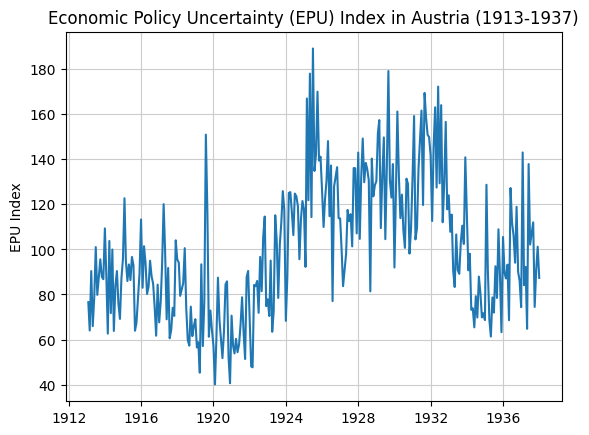

In [20]:
# Plot the EPU with a 5 year ticks on the x axis showing only the year
fig, ax = plt.subplots()
ax.plot(df_combined["End Date"], df_combined["EPU"])
plt.title("Economic Policy Uncertainty (EPU) Index in Austria (1913-1937)")
plt.ylabel("EPU Index")
ax.grid(color='#cccccc')
ax.set_label("End Date")